In [ ]:
from google.colab import userdata
import os

os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')

In [ ]:
dataset_directory = "Brain Tumor Data Set/Brain Tumor Data Set"

# Check if the dataset directory exists
if not os.path.exists(dataset_directory):
    # Download the dataset
    !kaggle datasets download -d preetviradiya/brian-tumor-dataset

    # Unzip the dataset without printing output
    !unzip -qq "brian-tumor-dataset.zip"

    # Delete the zip file
    os.remove("brian-tumor-dataset.zip")
else:
    print("Dataset already exists. Skipping download and unzip steps.")

Dataset URL: https://www.kaggle.com/datasets/preetviradiya/brian-tumor-dataset
License(s): GPL-2.0
100% 107M/107M [00:06<00:00, 20.3MB/s]
100% 107M/107M [00:06<00:00, 16.4MB/s]


In [ ]:
!pip -q install split-folders
!pip -q install torch-summary

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='darkgrid')
import copy
import os
import torch
from PIL import Image # A module that Provides functionality for image file formats.
from torch.utils.data import Dataset # For accessing and processing the data during training.
import torchvision
import torchvision.transforms as transforms # A module for editing images
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau # A PyTorch scheduler that adjusts the learning rate during training based on a specified metric, reducing it when the metric plateaus.
import torch.nn as nn
from torchvision import utils
from torchvision.datasets import ImageFolder
import splitfolders
from torchsummary import summary
import torch.nn.functional as F
import pathlib
from sklearn.metrics import confusion_matrix, classification_report
import itertools # For efficient looping and combining of iterables.
from tqdm.notebook import trange, tqdm # For progress bars to track the progress of loops or tasks.
from torch import optim
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Reading data
labels_df = pd.read_csv('/content/metadata.csv')
labels_df.head()

,Unnamed: 0,image,class,format,mode,shape
0,0,Cancer (1).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
1,1,Cancer (1).png,tumor,PNG,L,"(300, 240)"
2,2,Cancer (1).tif,tumor,TIFF,RGB,"(256, 256, 3)"
3,3,Cancer (10).jpg,tumor,JPEG,RGB,"(512, 512, 3)"
4,4,Cancer (10).tif,tumor,TIFF,RGB,"(256, 256, 3)"


In [ ]:
os.listdir('/content/Brain Tumor Data Set/Brain Tumor Data Set')

['Healthy', 'Brain Tumor']

In [ ]:
labels_df.shape

(4600, 6)

In [ ]:
# Dataset Path
data_dir = '/content/Brain Tumor Data Set/Brain Tumor Data Set'
data_dir = pathlib.Path(data_dir)

# Splitting dataset to train_set, val_set and test_set
splitfolders.ratio(data_dir, output='brain', seed=20, ratio=(0.8, 0.2))


# New dataset path
data_dir = '/content/brain'
data_dir = pathlib.Path(data_dir)

Copying files: 4600 files [00:00, 6469.64 files/s]


In [ ]:
# Image Augmentation
  # define transformation
transform = transforms.Compose(
    [
        transforms.Resize((256,256)),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406],std = [0.229, 0.224, 0.225])
   ]
)

In [ ]:
# Define an object of the custom dataset for the train and validation.
train_set = torchvision.datasets.ImageFolder(data_dir.joinpath("train"), transform=transform)
train_set.transform
val_set = torchvision.datasets.ImageFolder(data_dir.joinpath("val"), transform=transform)
val_set.transform

Compose(
    Resize(size=(256, 256), interpolation=bilinear, max_size=None, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

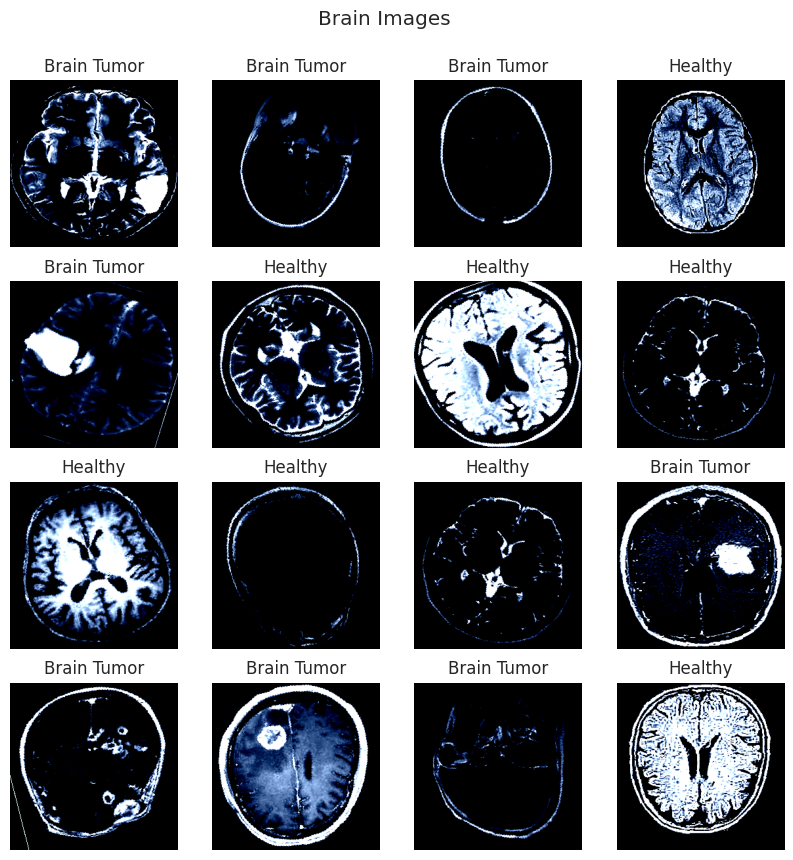

In [ ]:
# Visualiztion some images from Train Set
CLA_label = {
    0 : 'Brain Tumor',
    1 : 'Healthy'
}
figure = plt.figure(figsize=(10, 10))
cols, rows = 4, 4
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(CLA_label[label])
    plt.axis("off")
    img_np = img.numpy().transpose((1, 2, 0))
    # Clip pixel values to [0, 1]
    img_valid_range = np.clip(img_np, 0, 1)
    plt.imshow(img_valid_range)
    plt.suptitle('Brain Images', y=0.95)
plt.show()

In [ ]:
# Data Loader
# import and load train, validation
batch_size = 64

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, num_workers = 2)
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, num_workers = 2)

In [ ]:
# print shape for Training data and Validation data
for key, value in {'Training data': train_loader, "Validation data": val_loader}.items():
    for X, y in value:
        print(f"{key}:")
        print(f"Shape of X : {X.shape}")
        print(f"Shape of y: {y.shape} {y.dtype}\n")
        break

Training data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64

Validation data:
Shape of X : torch.Size([64, 3, 256, 256])
Shape of y: torch.Size([64]) torch.int64



# CNN Model

In [ ]:
# '''This function can be useful in determining the output size of a convolutional layer in a neural network,
# given the input dimensions and the convolutional layer's parameters.'''

# def findConv2dOutShape(hin,win,conv,pool=2):
#     # get conv arguments
#     kernel_size = conv.kernel_size
#     stride=conv.stride
#     padding=conv.padding
#     dilation=conv.dilation

#     hout=np.floor((hin+2*padding[0]-dilation[0]*(kernel_size[0]-1)-1)/stride[0]+1)
#     wout=np.floor((win+2*padding[1]-dilation[1]*(kernel_size[1]-1)-1)/stride[1]+1)

#     if pool:
#         hout/=pool
#         wout/=pool
#     return int(hout),int(wout)

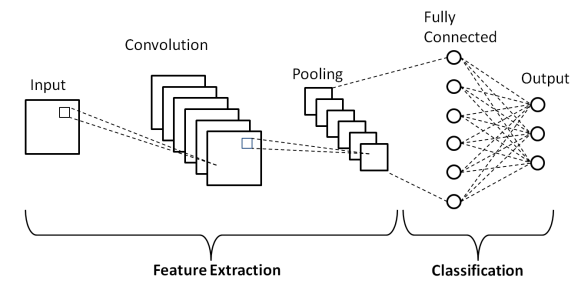

In [ ]:
# # Define Architecture For CNN_TUMOR Model
# class CNN_TUMOR(nn.Module):

#     # Network Initialisation
#     def __init__(self, params):

#         super(CNN_TUMOR, self).__init__()

#         Cin,Hin,Win = params["shape_in"]
#         init_f = params["initial_filters"]
#         num_fc1 = params["num_fc1"]
#         num_classes = params["num_classes"]
#         self.dropout_rate = params["dropout_rate"]

#         # Convolution Layers
#         self.conv1 = nn.Conv2d(Cin, init_f, kernel_size=3)
#         h,w=findConv2dOutShape(Hin,Win,self.conv1)
#         self.conv2 = nn.Conv2d(init_f, 2*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv2)
#         self.conv3 = nn.Conv2d(2*init_f, 4*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv3)
#         self.conv4 = nn.Conv2d(4*init_f, 8*init_f, kernel_size=3)
#         h,w=findConv2dOutShape(h,w,self.conv4)

#         # compute the flatten size
#         self.num_flatten=h*w*8*init_f
#         self.fc1 = nn.Linear(self.num_flatten, num_fc1)
#         self.fc2 = nn.Linear(num_fc1, num_classes)

#     def forward(self,X):

#         # Convolution & Pool Layers
#         X = F.relu(self.conv1(X));
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv2(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv3(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = F.relu(self.conv4(X))
#         X = F.max_pool2d(X, 2, 2)
#         X = X.view(-1, self.num_flatten)
#         X = F.relu(self.fc1(X))
#         X = F.dropout(X, self.dropout_rate)
#         X = self.fc2(X)
#         return F.log_softmax(X, dim=1)


In [ ]:
# params_model={
#         "shape_in": (3,256,256),
#         "initial_filters": 8,
#         "num_fc1": 100,
#         "dropout_rate": 0.25,
#         "num_classes": 2}

# # Create instantiation of Network class
# cnn_model = CNN_TUMOR(params_model)

# # define computation hardware approach (GPU/CPU)
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model = cnn_model.to(device)

In [ ]:
# summary(cnn_model, input_size=(3, 256, 256),device=device.type)

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            224
├─Conv2d: 1-2                            1,168
├─Conv2d: 1-3                            4,640
├─Conv2d: 1-4                            18,496
├─Linear: 1-5                            1,254,500
├─Linear: 1-6                            202
Total params: 1,279,230
Trainable params: 1,279,230
Non-trainable params: 0

In [ ]:
# loss_func = nn.NLLLoss(reduction="sum")

In [ ]:
# opt = optim.Adam(cnn_model.parameters(), lr=3e-4)
# lr_scheduler = ReduceLROnPlateau(opt, mode='min',factor=0.5, patience=20,verbose=1)

# Train

In [ ]:
# # Function to get the learning rate
# def get_lr(opt):
#     for param_group in opt.param_groups:
#         return param_group['lr']

# # Function to compute the loss value per batch of data
# def loss_batch(loss_func, output, target, opt=None):

#     loss = loss_func(output, target) # get loss
#     pred = output.argmax(dim=1, keepdim=True) # Get Output Class
#     metric_b=pred.eq(target.view_as(pred)).sum().item() # get performance metric

#     if opt is not None:
#         opt.zero_grad()
#         loss.backward()
#         opt.step()

#     return loss.item(), metric_b

# # Compute the loss value & performance metric for the entire dataset (epoch)
# def loss_epoch(model,loss_func,dataset_dl,opt=None):

#     run_loss=0.0
#     t_metric=0.0
#     len_data=len(dataset_dl.dataset)

#     # internal loop over dataset
#     for xb, yb in dataset_dl:
#         # move batch to device
#         xb=xb.to(device)
#         yb=yb.to(device)
#         output=model(xb) # get model output
#         loss_b,metric_b=loss_batch(loss_func, output, yb, opt) # get loss per batch
#         run_loss+=loss_b        # update running loss

#         if metric_b is not None: # update running metric
#             t_metric+=metric_b

#     loss=run_loss/float(len_data)  # average loss value
#     metric=t_metric/float(len_data) # average metric value

#     return loss, metric

In [ ]:
# def Train_Val(model, params,verbose=False):

#     # Get the parameters
#     epochs=params["epochs"]
#     loss_func=params["f_loss"]
#     opt=params["optimiser"]
#     train_dl=params["train"]
#     val_dl=params["val"]
#     lr_scheduler=params["lr_change"]
#     weight_path=params["weight_path"]

#     # history of loss values in each epoch
#     loss_history={"train": [],"val": []}
#     # histroy of metric values in each epoch
#     metric_history={"train": [],"val": []}
#     # a deep copy of weights for the best performing model
#     best_model_wts = copy.deepcopy(model.state_dict())
#     # initialize best loss to a large value
#     best_loss=float('inf')

# # Train Model n_epochs (the progress of training by printing the epoch number and the associated learning rate. It can be helpful for debugging, monitoring the learning rate schedule, or gaining insights into the training process.)

#     for epoch in tqdm(range(epochs)):

#         # Get the Learning Rate
#         current_lr=get_lr(opt)
#         if(verbose):
#             print('Epoch {}/{}, current lr={}'.format(epoch, epochs - 1, current_lr))


# # Train Model Process


#         model.train()
#         train_loss, train_metric = loss_epoch(model,loss_func,train_dl,opt)

#         # collect losses
#         loss_history["train"].append(train_loss)
#         metric_history["train"].append(train_metric)


# # Evaluate Model Process


#         model.eval()
#         with torch.no_grad():
#             val_loss, val_metric = loss_epoch(model,loss_func,val_dl)

#         # store best model
#         if(val_loss < best_loss):
#             best_loss = val_loss
#             best_model_wts = copy.deepcopy(model.state_dict())

#             # store weights into a local file
#             torch.save(model.state_dict(), weight_path)
#             if(verbose):
#                 print("Copied best model weights!")

#         # collect loss and metric for validation dataset
#         loss_history["val"].append(val_loss)
#         metric_history["val"].append(val_metric)

#         # learning rate schedule
#         lr_scheduler.step(val_loss)
#         if current_lr != get_lr(opt):
#             if(verbose):
#                 print("Loading best model weights!")
#             model.load_state_dict(best_model_wts)

#         if(verbose):
#             print(f"train loss: {train_loss:.6f}, dev loss: {val_loss:.6f}, accuracy: {100*val_metric:.2f}")
#             print("-"*10)

#     # load best model weights
#     model.load_state_dict(best_model_wts)

#     return model, loss_history, metric_history

In [ ]:
# # Define various parameters used for training and evaluation of a cnn_model

# params_train={
#  "train": train_loader,"val": val_loader,
#  "epochs": 60,
#  "optimiser": optim.Adam(cnn_model.parameters(),lr=3e-4),
#  "lr_change": ReduceLROnPlateau(opt,
#                                 mode='min',
#                                 factor=0.5,
#                                 patience=20,
#                                 verbose=0),
#  "f_loss": nn.NLLLoss(reduction="sum"),
#  "weight_path": "weights.pt",
# }

# # train and validate the model
# #cnn_model,loss_hist,metric_hist = Train_Val(cnn_model,params_train)
# cnn_model = torch.load('/content/Brain_Tumor_model.pt')
# cnn_model.eval()  # Set the model to evaluation mode

# # Optionally, move the model to GPU if available
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# cnn_model.to(device)

CNN_TUMOR(
  (conv1): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=12544, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=2, bias=True)
)

In [ ]:
# Convergence History Plot
# epochs=params_train["epochs"]
# fig,ax = plt.subplots(1,2,figsize=(12,5))

# sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["train"],ax=ax[0],label='loss_hist["train"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=loss_hist["val"],ax=ax[0],label='loss_hist["val"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["train"],ax=ax[1],label='Acc_hist["train"]')
# sns.lineplot(x=[*range(1,epochs+1)],y=metric_hist["val"],ax=ax[1],label='Acc_hist["val"]')

# ResNet18

In [ ]:
# import torchvision.models as models

# # Load the pre-trained ResNet-18 model
# model = models.resnet18(pretrained=True)

import torch
import torch.nn as nn
import torchvision.models as models

class VGG16_FPN_Decoder(nn.Module):
    def __init__(self, num_classes):
        super(VGG16_FPN_Decoder, self).__init__()

        # Load the pretrained VGG16 model
        vgg16 = models.vgg16(pretrained=True)
        self.features = vgg16.features

        # Define FPN layers
        self.fpn = nn.ModuleList([
            nn.Conv2d(512, 256, kernel_size=1),  # Top layer
            nn.Conv2d(512, 256, kernel_size=1),  # Middle layer
            nn.Conv2d(256, 256, kernel_size=1)   # Bottom layer
        ])

        # Define decoder layers
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, num_classes, kernel_size=2, stride=2)
        )

    def forward(self, x):
        # Extract feature maps from VGG16
        c3 = self.features[:17](x)  # Output from layer 3
        c4 = self.features[17:24](x)  # Output from layer 4
        c5 = self.features[24:](x)  # Output from layer 5

        # FPN top-down pathway
        p5 = self.fpn[0](c5)
        p4 = self.fpn[1](c4) + nn.functional.interpolate(p5, scale_factor=2, mode='nearest')
        p3 = self.fpn[2](c3) + nn.functional.interpolate(p4, scale_factor=2, mode='nearest')

        # Decoder pathway
        out = self.decoder(p3)
        return out

# Instantiate the model
model = VGG16_FPN_Decoder(num_classes=2)

In [ ]:
!pip -q install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 866.2/866.2 kB 46.1 MB/s eta 0:00:00


In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchmetrics import JaccardIndex

def dice_loss(pred, target, smooth = 1.):
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=2).sum(dim=2)
    loss = (1 - ((2. * intersection + smooth) / (pred.sum(dim=2).sum(dim=2) + target.sum(dim=2).sum(dim=2) + smooth)))
    return loss.mean()

def train(model, train_loader, val_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=3)

    # Initialize the IoU metric
    iou = JaccardIndex(num_classes=2).to(device)

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0

        for inputs, masks in train_loader:
            inputs, masks = inputs.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)

            # Combine Cross-Entropy and Dice Loss
            ce_loss = criterion(outputs, masks)
            dc_loss = dice_loss(torch.softmax(outputs, dim=1)[:, 1], masks)
            loss = ce_loss + dc_loss

            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

        train_loss /= len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_iou = 0.0

        with torch.no_grad():
            for inputs, masks in val_loader:
                inputs, masks = inputs.to(device), masks.to(device)
                outputs = model(inputs)

                # Compute validation loss
                ce_loss = criterion(outputs, masks)
                dc_loss = dice_loss(torch.softmax(outputs, dim=1)[:, 1], masks)
                loss = ce_loss + dc_loss
                val_loss += loss.item() * inputs.size(0)

                # Compute IoU
                val_iou += iou(outputs.argmax(dim=1), masks)

        val_loss /= len(val_loader.dataset)
        val_iou /= len(val_loader)

        # Adjust learning rate
        scheduler.step(val_loss)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

    return model

# Usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = VGG16_FPN_Decoder(num_classes=2).to(device)
train(model, train_loader, val_loader, num_epochs=50, device=device)

TypeError: JaccardIndex.__new__() missing 1 required positional argument: 'task'

In [ ]:
# Freeze all the pre-trained layers
for param in model.parameters():
    param.requires_grad = False

In [ ]:
# # Modify the last layer of the model
# num_classes = 2
# model.fc = torch.nn.Linear(model.fc.in_features, num_classes)

In [ ]:
def train(model, train_loader, val_loader, criterion, optimizer, num_epochs):
    # Train the model for the specified number of epochs
    for epoch in range(num_epochs):
        # Set the model to train mode
        model.train()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the train loader
        for inputs, labels in train_loader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Zero the optimizer gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # Backward pass and optimizer step
            loss.backward()
            optimizer.step()

            # Update the running loss and accuracy
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # Calculate the train loss and accuracy
        train_loss = running_loss / len(train_set)
        train_acc = running_corrects.double() / len(train_set)

        # Set the model to evaluation mode
        model.eval()

        # Initialize the running loss and accuracy
        running_loss = 0.0
        running_corrects = 0

        # Iterate over the batches of the validation loader
        with torch.no_grad():
            for inputs, labels in val_loader:
                # Move the inputs and labels to the device
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Update the running loss and accuracy
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

        # Calculate the validation loss and accuracy
        val_loss = running_loss / len(val_set)
        val_acc = running_corrects.double() / len(val_set)

        # Print the epoch results

        print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
              .format(epoch+1, num_epochs, train_loss, train_acc, val_loss, val_acc))

In [ ]:
# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Fine-tune the last layer for a few epochs
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Unfreeze all the layers and fine-tune the entire network for a few more epochs
for param in model.parameters():
    param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train(model, train_loader, val_loader, criterion, optimizer, num_epochs=10)

AttributeError: 'VGG16_FPN_Decoder' object has no attribute 'fc'

# Load model

In [ ]:
# torch.save(model,"/content/drive/MyDrive/brian_tumor_Resnet18.pt")
model = torch.load('/content/drive/MyDrive/brian_tumor_Resnet18.pt')

# Visualization

In [ ]:
def Ture_and_Pred(val_loader, model):
    y_true = []
    y_pred = []
    incorrect_predictions = []  # Store tuples of (image, true_label, predicted_label) for incorrect predictions
    for images, labels in val_loader:
        images = images.to(device)
        labels = labels.numpy()
        outputs = model(images)
        _, pred = torch.max(outputs.data, 1)
        pred = pred.detach().cpu().numpy()

        y_true.extend(labels)
        y_pred.extend(pred)

        # Check for incorrect predictions
        incorrect_mask = pred != labels
        for idx, incorrect in enumerate(incorrect_mask):
            if incorrect:
                incorrect_predictions.append((images[idx], labels[idx], pred[idx]))

    return y_true, y_pred, incorrect_predictions

# Obtain true labels, predicted labels, and incorrect predictions
y_true, y_pred, incorrect_predictions = Ture_and_Pred(val_loader, model)


In [ ]:
print(classification_report(y_true, y_pred), '\n\n')
cm = confusion_matrix(y_true, y_pred)

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       503
           1       0.99      1.00      0.99       418

    accuracy                           0.99       921
   macro avg       0.99      0.99      0.99       921
weighted avg       0.99      0.99      0.99       921
 




TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

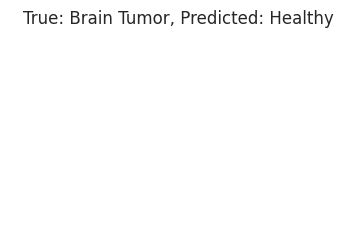

In [ ]:
# model.to('cpu')
# # Visualization of incorrectly predicted images
# figure = plt.figure(figsize=(20, 20))
# cols, rows = 4, 7
# for i in range(1, min(cols * rows, len(incorrect_predictions)) + 1):  # Limit to the number of incorrect predictions
#     img, true_label, predicted_label = incorrect_predictions[i-1]  # Get image, true label, and predicted label
#     figure.add_subplot(rows, cols, i)
#     plt.title(f"True: {CLA_label[true_label]}, Predicted: {CLA_label[predicted_label]}")
#     plt.axis("off")
#     img_np = img.numpy().transpose((1, 2, 0))
#     # Clip pixel values to [0, 1]
#     img_valid_range = np.clip(img_np, 0, 1)
#     plt.imshow(img_valid_range)
#     plt.suptitle('Incorrectly Predicted Images', y=0.95)
# plt.show()


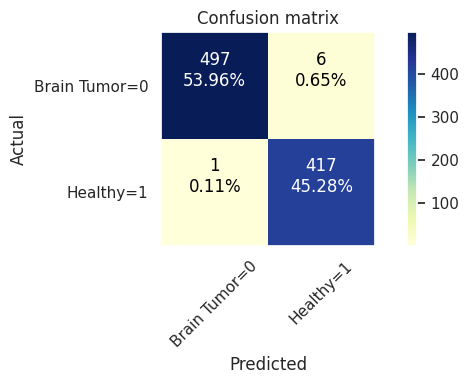

In [ ]:
# Confusion Matrix Plotting Function
def show_confusion_matrix(cm, CLA_label, title='Confusion matrix', cmap=plt.cm.YlGnBu):

    plt.figure(figsize=(7,4))
    plt.grid(False)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(CLA_label))

    plt.xticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()], rotation=45)
    plt.yticks(tick_marks, [f"{value}={key}" for key , value in CLA_label.items()])

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i,j]}\n{cm[i,j]/np.sum(cm)*100:.2f}%", horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.show()

show_confusion_matrix(cm, CLA_label)

In [ ]:
#To save the model
#torch.save(cnn_model, "Brain_Tumor_model.pt")

# Heat Map with **[TorchCAM](https://colab.research.google.com/github/frgfm/notebooks/blob/main/torch-cam/quicktour.ipynb#scrollTo=ZvXUBQbpdADe)**

In [ ]:
!pip -q install torchcam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from torch.nn.functional import softmax, interpolate
from torchvision.io.image import read_image
from torchvision.models import resnet18
from torchvision.transforms.functional import normalize, resize, to_pil_image

from torchcam.methods import SmoothGradCAMpp, LayerCAM
from torchcam.utils import overlay_mask

In [ ]:
cam_extractor = SmoothGradCAMpp(model)

In [ ]:
img = read_image("/content/Brain Tumor Data Set/Brain Tumor Data Set/Brain Tumor/Cancer (1514).jpg")

In [ ]:
input_tensor = normalize(resize(img, (224, 224)) / 255., [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

model.to("cpu")
# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

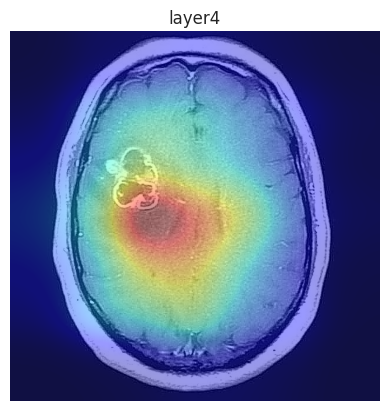

In [ ]:
# Overlayed on the image
for name, cam in zip(cam_extractor.target_names, cams):
  tumor_mask_heatmap = overlay_mask(to_pil_image(img), to_pil_image(cam.squeeze(0), mode='F'), alpha=0.6)
  plt.imshow(tumor_mask_heatmap); plt.axis('off'); plt.title(name); plt.show()

tensor(1.0000, grad_fn=<MaxBackward1>)


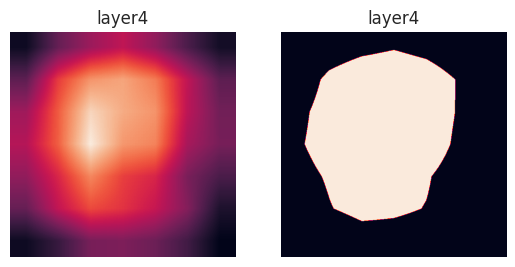

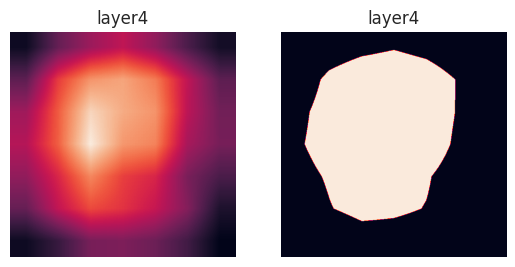

In [ ]:
cam_extractor.remove_hooks()
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model)

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
print(softmax(out, dim=1).max())
cams = cam_extractor(out.squeeze(0).argmax().item(), out)
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()
# Resize it
resized_cams = [resize(to_pil_image(cam.squeeze(0)), img.shape[-2:]) for cam in cams]
segmaps = [to_pil_image((resize(cam, img.shape[-2:]).squeeze(0) >= 0.5).to(dtype=torch.float32)) for cam in cams]
# Plot it
for name, cam, seg in zip(cam_extractor.target_names, resized_cams, segmaps):
  _, axes = plt.subplots(1, 2)
  axes[0].imshow(cam); axes[0].axis('off'); axes[0].set_title(name)
  axes[1].imshow(seg); axes[1].axis('off'); axes[1].set_title(name)
  plt.show()

In [ ]:
# Retrieve the CAM from several layers at the same time
cam_extractor = LayerCAM(model, ["layer2", "layer3"])

# Preprocess your data and feed it to the model
out = model(input_tensor.unsqueeze(0))
# Retrieve the CAM by passing the class index and the model output
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

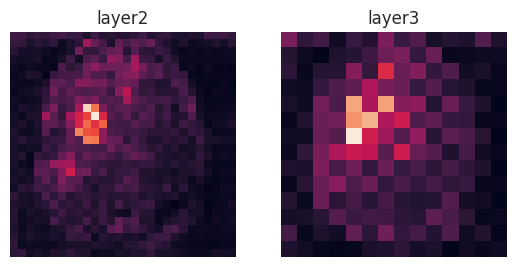

In [ ]:
# The raw CAM
_, axes = plt.subplots(1, len(cam_extractor.target_names))
for idx, name, cam in zip(range(len(cam_extractor.target_names)), cam_extractor.target_names, cams):
  axes[idx].imshow(cam.squeeze(0).numpy()); axes[idx].axis('off'); axes[idx].set_title(name);
plt.show()

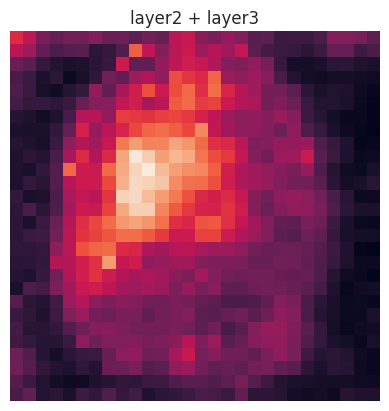

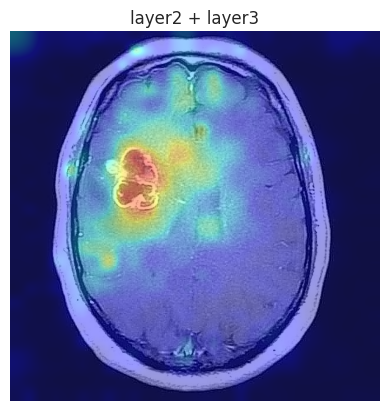

In [ ]:
# Let's fuse them
fused_cam = cam_extractor.fuse_cams(cams)
# Plot the raw version
plt.imshow(fused_cam.squeeze(0).numpy()); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()
# Plot the overlayed version
result = overlay_mask(to_pil_image(img), to_pil_image(fused_cam, mode='F'), alpha=0.6)
plt.imshow(result); plt.axis('off'); plt.title(" + ".join(cam_extractor.target_names)); plt.show()

In [ ]:
# Once you're finished, clear the hooks on your model
cam_extractor.remove_hooks()

# Feature Extraction

In [ ]:
from skimage import measure

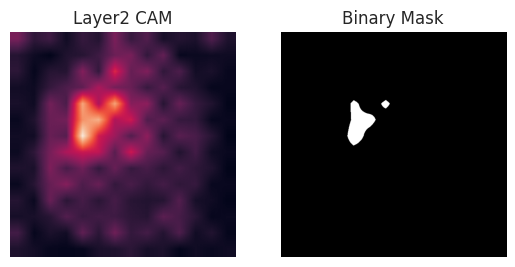

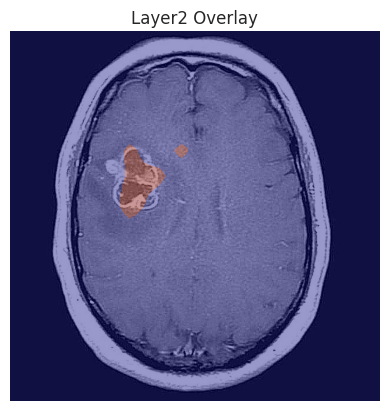

In [ ]:
cam_extractor = LayerCAM(model, ["layer3","layer2","layer4"])
out = model(input_tensor.unsqueeze(0))

# Retrieve CAM for layer2
cams = cam_extractor(out.squeeze(0).argmax().item(), out)

# Use only the first CAM, which corresponds to layer2
layer2_cam = cams[0]

# Resize and apply threshold to CAM
threshold = 0.7
resized_cam = resize(to_pil_image(layer2_cam.squeeze(0)), img.shape[-2:])
binary_mask = (resize(layer2_cam, img.shape[-2:]).squeeze(0) >= threshold).to(dtype=torch.float32)

# Plot CAM and binary mask
_, axes = plt.subplots(1, 2)
axes[0].imshow(resized_cam); axes[0].axis('off'); axes[0].set_title('Layer2 CAM')
axes[1].imshow(binary_mask, cmap='gray'); axes[1].axis('off'); axes[1].set_title('Binary Mask')
plt.show()

# Overlay binary mask on image
result = overlay_mask(to_pil_image(img), to_pil_image(binary_mask, mode='F'), alpha=0.6)
plt.imshow(result); plt.axis('off'); plt.title('Layer2 Overlay'); plt.show()

# Clear hooks
cam_extractor.remove_hooks()

In [ ]:
# Assuming you have a segmented tumor region stored in the variable 'tumor_mask'
tumor_mask = binary_mask
labeled_tumor = measure.label(tumor_mask)
tumor_properties = measure.regionprops(labeled_tumor)

shape_features = []
for prop in tumor_properties:
    shape_features.append({
        'area': prop.area,
        'perimeter': prop.perimeter,
        'eccentricity': prop.eccentricity,
        'solidity': prop.solidity
    })

In [ ]:
tumor_mask.unique()

tensor([0., 1.])

In [ ]:
from PIL import Image
from scipy import stats

# Assuming you have the segmented tumor region stored in the variable 'tumor_mask'
tumor_mask_expanded = tumor_mask.unsqueeze(0).expand_as(img)

# Extract tumor intensities
tumor_intensities = img[tumor_mask_expanded].cpu().numpy()


first_order_features = {
    'mean': np.mean(tumor_intensities),
    'std_dev': np.std(tumor_intensities),
    'skewness': stats.skew(tumor_intensities),
    'kurtosis': stats.kurtosis(tumor_intensities)
}

IndexError: tensors used as indices must be long, int, byte or bool tensors

In [ ]:
pip -q install pyradiomics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 55.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 46.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 110.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.8/117.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 526.7/526.7 kB 29.8 MB/s eta 0:00:00


In [ ]:
import SimpleITK as sitk
import numpy as np
from radiomics import featureextractor
import six

def prepare_data(img, tumor_mask):
    # Convert PyTorch tensor to NumPy array
    tumor_image_np = img.cpu().numpy().transpose(1, 2, 0)

    # Convert PIL Image to NumPy array
    tumor_mask_np = np.array(tumor_mask)

    # Ensure the image is grayscale
    if tumor_image_np.shape[-1] == 3:
        tumor_image_gray = np.mean(tumor_image_np, axis=-1)
    else:
        tumor_image_gray = tumor_image_np.squeeze()

    # Ensure the mask is binary
    tumor_mask_np = (tumor_mask_np > 0).astype(np.uint8)

    print("Image shape:", tumor_image_gray.shape)
    print("Mask shape:", tumor_mask_np.shape)
    print("Image dtype:", tumor_image_gray.dtype)
    print("Mask dtype:", tumor_mask_np.dtype)
    print("Unique values in mask:", np.unique(tumor_mask_np))

    return tumor_image_gray, tumor_mask_np

def convert_to_sitk(image_np, mask_np):
    image_sitk = sitk.GetImageFromArray(image_np.astype(np.float32))

    # Convert mask to SimpleITK image using a different method
    mask_sitk = sitk.GetImageFromArray(mask_np)
    mask_sitk = sitk.Cast(mask_sitk, sitk.sitkUInt8)

    print("Unique values in SimpleITK mask:", np.unique(sitk.GetArrayFromImage(mask_sitk)))

    return image_sitk, mask_sitk

def init_feature_extractor():
    settings = {
        'binWidth': 25,
        'resampledPixelSpacing': None,
        'interpolator': sitk.sitkBSpline
    }
    return featureextractor.RadiomicsFeatureExtractor(**settings)

def extract_features(extractor, image_sitk, mask_sitk):
    try:
        result = extractor.execute(image_sitk, mask_sitk)
        return result
    except Exception as e:
        print("Error during feature extraction:", str(e))
        return None

# Main execution
try:
    # Prepare data
    image_np, mask_np = prepare_data(img, tumor_mask)

    # Convert to SimpleITK
    image_sitk, mask_sitk = convert_to_sitk(image_np, mask_np)

    # Initialize extractor
    extractor = init_feature_extractor()

    # Extract features
    result = extract_features(extractor, image_sitk, mask_sitk)

    if result:
        print("Extracted features:")
        for key, value in six.iteritems(result):
            print("\t", key, ":", value)
    else:
        print("Feature extraction failed.")
except Exception as e:
    print("An error occurred:", str(e))


INFO:radiomics.featureextractor:No valid config parameter, using defaults: {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True}
INFO:radiomics.featureextractor:Enabled image types: {'Original': {}}
INFO:radiomics.featureextractor:Enabled features: {'firstorder': [], 'glcm': [], 'gldm': [], 'glrlm': [], 'glszm': [], 'ngtdm': [], 'shape': []}
INFO:radiomics.featureextractor:Applying custom setting overrides: {'binWidth': 25, 'resampledPixelSpacing': None, 'interpolator': 23}
INFO:radiomics.featureextractor:Calculating features with label: 1
INFO:radiomics.featureextractor:Loading image and mask
Shape features are only available 3D input (for 2D input, use shape2D). Found 2D input
INFO:radiomics.featureextractor:

Image shape: (630, 630)
Mask shape: (630, 630)
Image dtype: float64
Mask dtype: uint8
Unique values in mask: [0 1]
Unique values in SimpleITK mask: [0 1]
Extracted features:
	 diagnostics_Versions_PyRadiomics : v3.0.1
	 diagnostics_Versions_Numpy : 1.25.2
	 diagnostics_Versions_SimpleITK : 2.3.1
	 diagnostics_Versions_PyWavelet : 1.6.0
	 diagnostics_Versions_Python : 3.10.12
	 diagnostics_Configuration_Settings : {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': False, 'normalizeScale': 1, 'removeOutliers': None, 'resampledPixelSpacing': None, 'interpolator': 23, 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 25}
	 diagnostics_Configuration_EnabledImageTypes : {'Original': {}}
	 diagnostics_Image-original_Hash : 6a4f7aa70fbf204046db797990ea82c77854d756
	 diagnostics_Image-original_Dimensionality : 2D
	 diagnostics_Image-original_Spacing : (1.0, 1.0)
	 d

In [ ]:
all_features = {**shape_features[0], **first_order_features}

# Clinial BERT

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def prepare_feature_input(features, max_features=10):
    feature_text = "Radiomic features of the tumor:\n"
    for i, (key, value) in enumerate(features.items()):
        if i >= max_features:
            feature_text += "... (additional features omitted)\n"
            break
        if isinstance(value, (int, float)):
            feature_text += f"- {key}: {value:.4f}\n"
        else:
            feature_text += f"- {key}: {value}\n"
    return feature_text

def create_prompt(feature_text):
    prompt = f"""Analyze the following radiomic features of a brain tumor and provide a brief explanation:

{feature_text}

Explanation:"""
    return prompt

def generate_explanation(prompt):
    tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")
    model = AutoModelForCausalLM.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", is_decoder=True)

    inputs = tokenizer(prompt, return_tensors="pt", max_length=512, truncation=True)

    with torch.no_grad():
        output = model.generate(
            inputs.input_ids,
            max_length=512,
            num_return_sequences=1,
            no_repeat_ngram_size=2,
            top_k=50,
            top_p=0.95,
            temperature=0.7
        )

    explanation = tokenizer.decode(output[0], skip_special_tokens=True)
    return explanation

def format_output(explanation):
    sections = explanation.split('\n\n')
    formatted_output = "# Brain Tumor Analysis Report\n\n"

    if len(sections) > 0:
        formatted_output += "## Radiomic Feature Analysis\n\n"
        formatted_output += sections[0] + "\n\n"

    if len(sections) > 1:
        formatted_output += "## Clinical Implications\n\n"
        formatted_output += sections[1] + "\n\n"

    return formatted_output

def analyze_tumor(features):
    feature_text = prepare_feature_input(features)
    prompt = create_prompt(feature_text)
    explanation = generate_explanation(prompt)
    formatted_output = format_output(explanation)
    return formatted_output

# Example usage
features = {
    'original_shape_Elongation': 0.7532,
    'original_firstorder_Energy': 1256789.3245,
    'original_glcm_Correlation': 0.9876,
    # Add more features as needed
}

report = analyze_tumor(features)
print(report)


# Brain Tumor Analysis Report

## Radiomic Feature Analysis

analyze the following radiomic features of a brain tumor and provide a brief explanation : radiomic features of the tumor : - original _ shape _ elongation : 0. 7532 - original _ firstorder _ energy : 1256789. 3245 - original _ glcm _ correlation : 0. 9876 explanation :..!!?! \ \! | |! v v V _ _! _ v!O O O o o OOO oOooOOsOsOSOSOOOMOMMM M MMmM m mmm mMOOPOPOEEOONONOMUMUMMOMAMAMOMIMIMUMOM M m MmOOLOLOOXOXOMONOAAOMUMIMOMEMEMIMAMIMMIMEMUMAMUMEMOMOYYOMSMIMLMLMUMLMIM MIMMMIMDMIMONUM MOMMMOMLMOMMGMAMEMAMMEMLMEMMLMMIIMMGMG MAMMGOMDMDMOMmUMmOM OOMOROMOLOMOPOMZOMMIIMSMUMUSUSUM mOMMDMDMMMDMDOMYUMDMAM MUMTMOMATATOMOXUMICOMAVAVOMTMIMCMIMYIM mIM I IIMmIMICICIMIDIDIMATIMOAMATAMICUMCUOMIDOMEDIMMGIMMOIMGMIMIIMCUCUUMUUMMMMMMMMAMDMUMI IIOMCUIMMIUMMIMIMMIOMIUMSMOMCMOMICIAMLMAMYAMCMAMMMUMOPUMGMOMRIIMMPIMMEIMOLUMIDAMIDUMOIMISIMBMOMROOMMEOMISISMCMCMMY YIMIRIMAVIMINIM OIMMFOMADIMIONIM MIIMCIIMADADIDMIAMMICUIDMICYIDICIDYICACACICAMCUICCUAMmAM IIDRDIDI

In [ ]:
!pip -q install openai
!pip install --upgrade openai


In [ ]:
import openai

def generate_explanation_gpt3(prompt):
    client = openai.OpenAI(api_key='sk-proj-M14xZWbnJRxJ3lndoPB2T3BlbkFJz3rlEqBdtFEgHCVmlIhM')

    response = client.chat.completions.create(
        model="gpt-3.5-turbo",
        messages=[
            {"role": "system", "content": "You are a medical expert analyzing brain tumor radiomic features."},
            {"role": "user", "content": prompt}
        ],
        max_tokens=40,
        n=1,
        temperature=0.7
    )

    explanation = response.choices[0].message.content.strip()
    return explanation


In [ ]:
s = f"this is the featurs of a brain tumor: {features}"
print(generate_explanation_gpt3(s))

RateLimitError: Error code: 429 - {'error': {'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, read the docs: https://platform.openai.com/docs/guides/error-codes/api-errors.', 'type': 'insufficient_quota', 'param': None, 'code': 'insufficient_quota'}}